In [9]:
from cebmf_torch import *
import torch
import numpy as np

import matplotlib.pyplot as plt

In [10]:
betahat = torch.tensor([1.,2.,3.,4.,5.])
sebetahat = torch.tensor([1.,0.4,5.,1.,1.])
mult = torch.sqrt(torch.tensor(2.0)).item()
res = ash(betahat, sebetahat, prior="exp", mult=mult, method="em", steps=3000, batch_size=5)
expected_log_lik = -15.244064765169643
expected_scale = np.array([ 0.        , 0.02929687, 0.04143204, 0.05859375, 0.08286408,
                                0.1171875 , 0.16572815, 0.234375  , 0.3314563 , 0.46875   ,
                                0.66291261, 0.9375    , 1.32582521, 1.875     , 2.65165043,
                                3.75      , 5.30330086, 7.5       ])


In [11]:
betahat

tensor([1., 2., 3., 4., 5.])

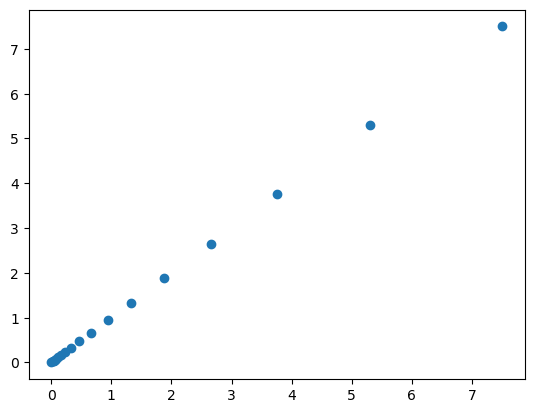

In [12]:
plt.scatter( res.scale.cpu().numpy(), expected_scale)

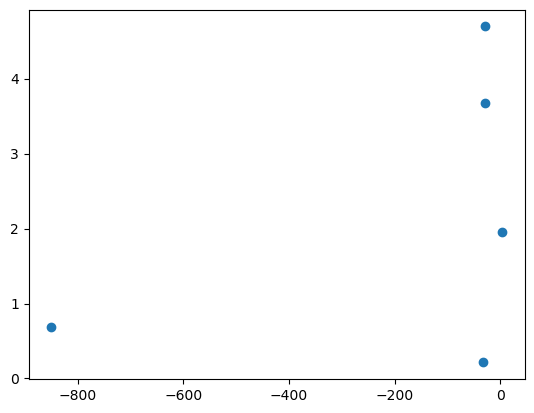

In [13]:
plt.scatter(res.post_mean.cpu().numpy(), np.array([0.21361966, 1.95003336, 0.68125659, 3.67773689, 4.69599116]))

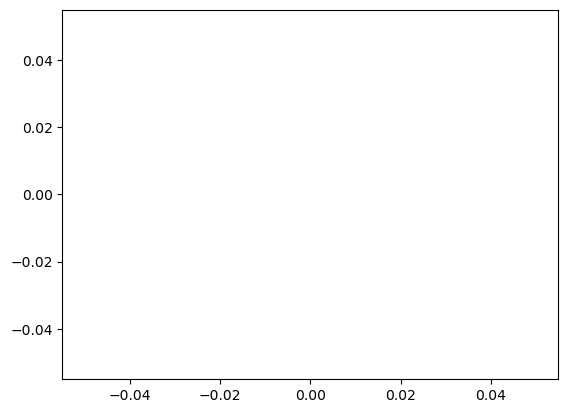

In [14]:
plt.scatter(res.post_mean2.cpu().numpy(), np.array([ 0.34021317,  3.96295414,  3.17114472, 14.58222929, 23.05642398]))

In [15]:
res.log_lik 

15569.78515625

In [16]:
expected_log_lik

-15.244064765169643

In [ ]:
 

def test_optimize_pi_and_posterior_mean_norm_shape():
    betahat = torch.tensor([1.,2.,3.,4.,5.])
    sebetahat = torch.tensor([1.,0.4,5.,1.,1.]) 
    scale = autoselect_scales_mix_exp(betahat, sebetahat)
    L = get_data_loglik_exp(betahat, sebetahat,   scale)
    pi = optimize_pi_logL_torch(L, penalty=10, method="em", steps=5000, batch_size=5)
    out = posterior_mean_exp(betahat, sebetahat, torch.log(pi+1e-32), scale)
    result = torch.exp(L) * torch.exp(pi)
    assert result.shape[0] == 5
